# Anamoly Detection Of Hardware Trojans Based On Simulated Power Consumption Data
## A Machine Learning Approach Using Isolation Forest


In this notebook, we showcase a machine learning approach to detect anomalous power consumption of IC chip due to a trojan introduced in the hardware supply chain. Validation of this approach using real hardware data and additional features will significantly improve robustness. It suggests the feasibility of integrating ML and hardware security to provide mitigation mechanisms in supply chain.

#### Objective: 
        - To provide a proof-of-concept on the non-invasive approach of detecting hardware trojans

#### Steps: 
        1. Simulate Power Consumption Data:
            -Create a controlled dataset that mimics normal and anomalous power consumption patterns observed in ICs
        2. Apply Machine Learning for Anomaly Detection:
            -Utilize the Isolation Forest algorithm to identify anomalies in power consumption.
        3. Evaluate Model Performance:
            -Assess the detection capabilities of the model using key metrics such as accuracy, precision, recall, F1 score, precision-recall curve and ROC .


###### Note:
###### Simulated data may not fully capture the complexities of actual power consumption patterns. Moreover, real hardware ICs may exhibit noise, environmental effects, or other subtle anomalies that are absent in dummy data. Hence, testing on real-world hardware data would be a crucial future work.




### Data Simulation

In [1]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Setting random seed for reproducibility
np.random.seed(42)

# Generate normal data (power consumption between 20-30 mW)
normal_data = np.random.normal(loc=25, scale=2, size=1000)

# Generate anomalous data (power spikes indicating Trojan activity)
anomalous_data = np.random.normal(loc=35, scale=3, size=50)

# Combine the data
power_data = np.concatenate([normal_data, anomalous_data])
labels = np.concatenate([np.zeros(len(normal_data)), np.ones(len(anomalous_data))])

# Create a DataFrame
df = pd.DataFrame({"PowerConsumption": power_data, "Label": labels})

### Visualizing the Simulated Data

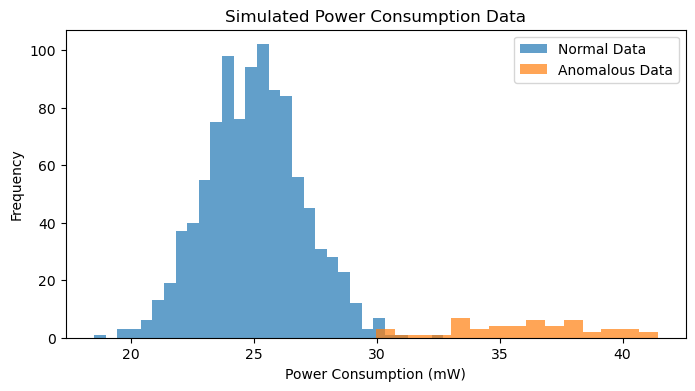

In [2]:
# Plot the data
plt.figure(figsize=(8, 4))
plt.hist(normal_data, bins=30, alpha=0.7, label='Normal Data')
plt.hist(anomalous_data, bins=15, alpha=0.7, label='Anomalous Data')
plt.xlabel("Power Consumption (mW)")
plt.ylabel("Frequency")
plt.title("Simulated Power Consumption Data")
plt.legend()
plt.show()

### Training the model using Isolation Forest

In [3]:
from sklearn.ensemble import IsolationForest

# Initialize Isolation Forest and fit the model on power consumption data
model = IsolationForest(contamination=0.048, random_state=42)
model.fit(df[["PowerConsumption"]])

# Get anomaly scores and predictions (1 for normal, -1 for anomaly)
df["Anomaly_Score"] = model.decision_function(df[["PowerConsumption"]])
df["Prediction"] = model.predict(df[["PowerConsumption"]])
df["Anomaly"] = df["Prediction"].apply(lambda x: 1 if x == -1 else 0)

# Calculate detection accuracy
accuracy = (df["Anomaly"] == df["Label"]).mean()
detection_accuracy = accuracy

### Cross Validation

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Initializing KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

# Perform cross-validation
for train_index, test_index in kf.split(df):
    # Split the data into training and testing sets
    X_train, X_test = df.iloc[train_index][["PowerConsumption"]], df.iloc[test_index][["PowerConsumption"]]
    y_test = df.iloc[test_index]["Label"]

    # Initialize and fit the Isolation Forest model
    model = IsolationForest(contamination=0.048, random_state=42)
    model.fit(X_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Convert predictions (-1 for anomaly, 1 for normal) to (1 for anomaly, 0 for normal)
    y_pred = np.where(y_pred == -1, 1, 0)

    # Calculate accuracy and the mean accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
# Calculate the mean accuracy
mean_accuracy = np.mean(accuracies)

### Visualizing the anomalies in the data

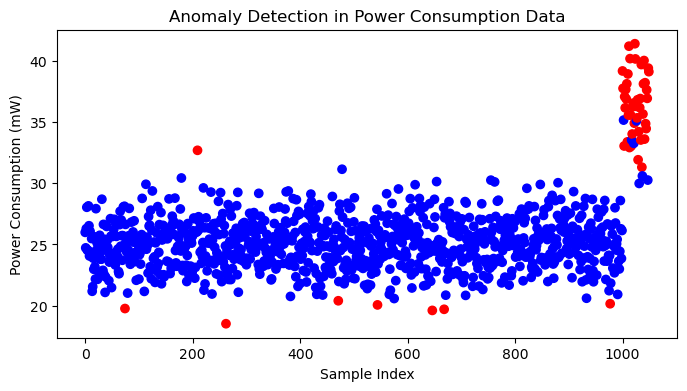

In [5]:
#plotting the data
plt.figure(figsize=(8, 4))
colors = ['blue' if x == 0 else 'red' for x in df["Anomaly"]]
plt.scatter(range(len(df)), df["PowerConsumption"], c=colors)
plt.xlabel("Sample Index")
plt.ylabel("Power Consumption (mW)")
plt.title("Anomaly Detection in Power Consumption Data")
plt.show()

### Evaluating the model

##### The following evaluation metrics are used: 
- Accuracy is the proportion of all correctly classified instances (both normal and anomalous) to the total number of instances.  
  Accuracy = (True Positives (TP) + True Negatives (TN)) / Total Instances
- Precision measures the proportion of instances classified as anomalies that are actually anomalies.  
  Precision = True Positives (TP) / (True Positives (TP) + False Positives (FP))
- Recall (also called Sensitivity or True Positive Rate) measures the proportion of actual anomalies that are correctly detected by the model.  
  Recall = True Positives (TP) / (True Positives (TP) + False Negatives (FN))
- Precision-Recall Curve: This shows the trade-off between precision (positive predictive value) and recall (true positive rate) at various thresholds.  
  AUC-PR (Area Under the Precision-Recall Curve):
      Measures how well the model balances precision and recall across thresholds.
      Useful for imbalanced datasets, where anomalies (Trojan-infected ICs) are rare.

- The ROC Curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various thresholds.  
  ROC-AUC:
    Measures the model's ability to distinguish between normal and anomalous instances.
    A value of 1 indicates perfect separation, while 0.5 indicates no better than random guessing.
    

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score

#Showcasing the output of accuracy before and after cross validation
print(f"Detection Accuracy: {detection_accuracy * 100:.2f}%")
print(f"Cross-Validated Accuracy: {mean_accuracy * 100:.2f}%")

# Calculate precision and recall for the final predictions
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1 * 100:.2f}%")

Detection Accuracy: 98.57%
Cross-Validated Accuracy: 98.67%
Precision: 83.33%
Recall: 83.33%
F1 Score: 83.33%


AUC-PR: 0.80
ROC-AUC: 0.99


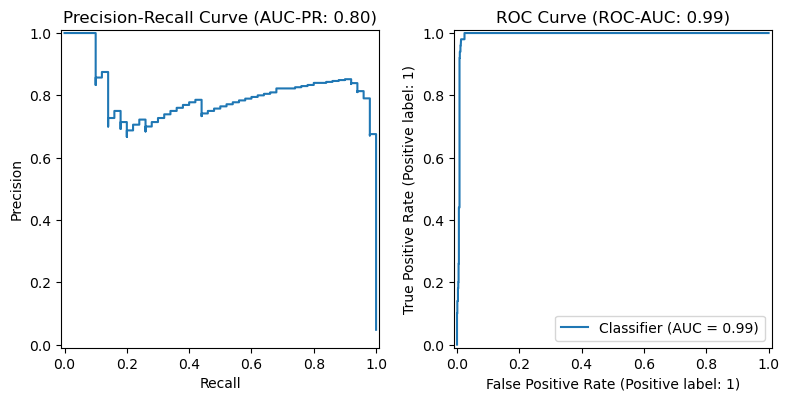

In [7]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc, RocCurveDisplay, PrecisionRecallDisplay

precision, recall, thresholds = precision_recall_curve(df["Label"], -df["Anomaly_Score"])
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr:.2f}")

roc_auc = roc_auc_score(df["Label"], -df["Anomaly_Score"])
print(f"ROC-AUC: {roc_auc:.2f}")

fig, axes = plt.subplots(1, 2, figsize=(8, 6))
# Precision-Recall Curve
PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=axes[0])
axes[0].set_title(f"Precision-Recall Curve (AUC-PR: {auc_pr:.2f})")

# ROC Curve
RocCurveDisplay.from_predictions(df["Label"], -df["Anomaly_Score"], ax=axes[1])
axes[1].set_title(f"ROC Curve (ROC-AUC: {roc_auc:.2f})")

plt.tight_layout()
plt.show()

-  Accuracy of 98.57% indicates that our model is highly effective at identifying both normal and Trojan-infected instances.
- The model's precision indicates that 83.33% of the cases flagged as anomalies are genuinely Trojan-infected.
- The model's recall suggests that 83.33% of Trojan-infected instances were successfully identified by the model.
- The F1 Score reflects a good trade-off between precision and recall.
- High ROC-AUC (0.99): Our model is able to distinguish between classes.
- Moderate AUC-PR (0.80): This suggests that our model needs improvements in handling imbalanced data more effectively, as some anomalies might still be missed or result in false positives.


### Key Takeaways
This project demonstrates the significance of machine learning in detecting potential threats and the need for such mitigation techniques for supply chain security. This work lays the groundwork for scalable, non-invasive methods for protecting hardware supply chain against Hardware Trojans. Hence, the final learnings of this simulation are as follows:

1. The Isolation Forest algorithm demonstrated its capability to detect anomalies in power consumption data, achieving a high detection accuracy of 98.57%.

2. While the model achieved high recall (minimizing missed anomalies), precision needs improvement to reduce false positives. A balanced F1 Score highlights the trade-off between precision and recall in anomaly detection.

3. Cross-validated accuracy (98.67%) was consistent with detection accuracy, indicating the model generalizes well to unseen data.

4. Anomalies represented a very small fraction of the total data (~0.5%), making the detection task challenging. Future work should address this imbalance through feature engineering or advanced algorithms.

5. Incorporating real-world hardware data is essential for validating the model's performance in practical scenarios.Exploring alternative algorithms (e.g., One-Class SVM, Autoencoders) and additional features can further enhance detection capabilities.

6. Early detection of anomalies can significantly reduce risks in hardware supply chains, ensuring the integrity and security of critical systems.

